In [1]:
import pyarabic.araby as araby
import re
import string
import unicodedata as ud
import codecs
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tashaphyne.stemming import ArabicLightStemmer
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from scipy import stats


In [4]:
######### GET DATA ##############

#import  stop words 
def get_stop_words():
    path = "stop_words.txt"
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

# import Emojis 
def get_emojis():
    with codecs.open("emoji.txt", "r", encoding="utf-8", errors="ignore") as myfile:
         positive_emoji=myfile.read()
    positive_emoji=positive_emoji.split("\r\n")
    positive_emoji=positive_emoji[1:len(positive_emoji)-1] 
    with codecs.open("neg_emoji.txt", "r", encoding="utf-8", errors="ignore") as myfie:
        neg_emoji=myfie.read()
    neg_emoji=neg_emoji.split("\r\n")
    neg_emoji=neg_emoji[1:len(neg_emoji)-1]
    return positive_emoji,neg_emoji
    

#import (Text , label) 
def get_data():
    path="data_text.txt"
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        text = myfile.read()
    sentences=text.split("@")
    sentences=[x.split("\r\n") for x in sentences]
    sentences=sentences[1:len(sentences)-1]
    df=pd.DataFrame(sentences)
    df.columns = ['sentiment','sentence']
    return df

############## PREPROCESSING DATA ################


#Remove stop words 
def remove_stp_words(text):
    text_words = []
    words = text.split(" ")
    stop_words = get_stop_words()
    for word in words:
        if word not in stop_words:
            text_words.append(word)
    return ' '.join(text_words)


#Emoticons_Regex 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)

#Tokenizing_the_text :
def tokenize(s):
    return tokens_re.findall(s)


#Normalize_the_text:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


#Remove-repeating_char :
def remove_repeating_char(text):
     #return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)     # keep 2 repeat

#Detecting_Emojis_REGEX
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

#Transform Emojis to their sentiment 
def emoji_to_text(text):
    text_words = []
    words = text.split(" ")
    positive_emoji,neg_emoji=get_emojis()
    for word in words:
        if emoji_pattern.search(word):
            if word in positive_emoji :
                word='ايجابي'
            if word in neg_emoji :
                word='سلبي'
        text_words.append(word)
    return ' '.join(text_words)

#REMOVING_Punctuation
def remove_punc(text):
    return ''.join(c for c in text if not ud.category(c).startswith('P'))


#Stemmer_LIGHT : Remove suffixes and affixes 
ArListem = ArabicLightStemmer()
def stemmer_light(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)

#Root Stemming :  Transform the wrod into its root form
def stemmer_root(text):
    text_words = []
    words = text.split(" ")
    for c in words:
        stem = ArListem.light_stem(c)
        text_words.append(stem)
    return ' '.join(text_words)


############ DARIJA TEXT PREPROCESSIG #########

def data_clean(stp_words=False,stem=True,tok=True,emojis=False):
    data = get_data()
    sentences = data['sentence']
    #Remove ـــ character wich is used a lot in arabic for exhibition
    sentences = [araby.strip_tatweel(text) for text in sentences] 
    #Remove Punctiation 
    sentences = [remove_punc(text) for text in sentences]
    if emojis==False :
        sentences = [emoji_to_text(text) for text in sentences] 
    #Remove Repeating character
    sentences = [remove_repeating_char(text) for text in sentences]
    #Remoce arabic diacritics
    sentences = [araby.strip_tashkeel(text) for text in sentences]
    if stp_words==True :
        sentences = [remove_stp_words(text) for text in sentences]
    if stem==True:
        sentences = [stemmer_light(text) for text in sentences]
    sentences = [normalize_arabic(text) for text in sentences]
    sentences = [araby.normalize_hamza(text) for text in sentences]
    if tok==True:
        sentences = [tokenize(text) for text in sentences]
    return sentences         

<BarContainer object of 2 artists>

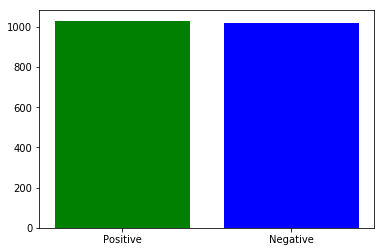

In [7]:
######## TF_IDF ############ TERM FREQUENCY _ INVERSE DOCUMENT FREQUENCY
def get_tfidf():
    data,sentiment = data_clean(stp_words=True,stem=True,tok=False,emojis=False)
    X_train, X_test, y_train, y_test = train_test_split(data, sentiment, test_size=0.2, random_state=1)
    vectorizer = TfidfVectorizer(ngram_range = (1,1))
    X_tr = vectorizer.fit_transform(X_train)
    X_tes = vectorizer.transform(X_test)
    return X_tr,X_tes,y_train,y_test
########## Document-Term Matrix(DTM) ######
def doc_term_frec():
    data,sentiment = data_clean(stp_words=True,stem=True,tok=False,emojis=False)
    X_train, X_test, y_train, y_test = train_test_split(data, sentiment, test_size=0.2, random_state=1)
    cv = CountVectorizer(ngram_range = (1,1))
    X_tr= cv.fit_transform(X_train)
    X_tes = cv.transform(X_test)
    return X_tr,X_tes,y_train,y_test



plt.bar(["Positive","Negative"],[sentiment[sentiment=='P'].count(),sentiment[sentiment=='N'].count()],color=['g','b']) 

In [6]:
data_set =get_data()
sentiment = data_set['sentiment']
sentimen =np.array( [1 if sen == 'P' else 0 for sen in sentiment])

X_train, X_test, y_train, y_test = doc_term_frec()
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1642, 9112) (1642,)
(411, 9112) (411,)


In [8]:
clf = MultinomialNB(alpha=0.1, fit_prior= False).fit(X_train, y_train)
log = LogisticRegression( solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)                                                                    
d_tree = tree.DecisionTreeClassifier().fit(X_train,y_train)
svm = LinearSVC().fit(X_train,y_train)
print(classification_report( log.predict(X_test) , y_test))
print("Logistic Regression:",accuracy_score( log.predict(X_test) , y_test ),accuracy_score( log.predict(X_train) , y_train ))
print(classification_report( d_tree.predict(X_test) , y_test))
print("Decision Tree Accuracy:",accuracy_score( d_tree.predict(X_test) , y_test ),accuracy_score( d_tree.predict(X_train) , y_train ))
print(classification_report( clf.predict(X_test) , y_test))
print("MultinomialNB Accuracy:",accuracy_score( clf.predict(X_test) , y_test ),accuracy_score( clf.predict(X_train) , y_train ))
print(classification_report( svm.predict(X_test) , y_test))
print("SVM Accuracy:",accuracy_score( svm.predict(X_test) , y_test ),accuracy_score( svm.predict(X_train) , y_train ))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       192
           1       0.87      0.77      0.82       219

    accuracy                           0.82       411
   macro avg       0.82      0.82      0.82       411
weighted avg       0.82      0.82      0.82       411

Logistic Regression: 0.8175182481751825 0.9987819732034104
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       248
           1       0.66      0.79      0.72       163

    accuracy                           0.76       411
   macro avg       0.75      0.76      0.75       411
weighted avg       0.77      0.76      0.76       411

Decision Tree Accuracy: 0.7591240875912408 0.9993909866017052
              precision    recall  f1-score   support

           0       0.73      0.87      0.79       182
           1       0.88      0.74      0.80       229

    accuracy                           0.80       411
   macr

In [1]:
####### Tuning Hyperparameters ####### 

#Grid Search For SVM
def svc_param_selection(X, y, nfolds):
    Cs = [9.5,9]
    gammas = [0.25,0.2]
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel' : ['rbf']}
    grid_search = GridSearchCV(SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_score_,grid_search.best_params_

svc_param_selection(X_train, y_train, 5)

#Grid Search For Naive Bayes 
def svc_param_selection(X, y):
    grid_params = {
      'alpha': [0.35,0.3,0.25],
      'fit_prior': [True, False]}
    crossvalidation=KFold(n_splits=100,shuffle=True,random_state=1)
    cl = GridSearchCV(clf, grid_params,cv=crossvalidation)
    cl.fit(X, y)
    return cl.best_params_,cl.best_score_
##### Random Search for SVM


rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.01, 1),
            "kernel":['rbf','linear','sigmoid']}
              
rand_search = RandomizedSearchCV(svm, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 3, random_state = 2) 
rand_search.fit(X_train, y_train) 
rand_search.best_params_

NameError: name 'X_train' is not defined